In [10]:
from src.data_gen import data_gen, data_gen_xu
from src.gsc_ipca import gsc_ipca
from src.gsc_ife import gsc_ife
from src.scm import scm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
color

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

### Data Generation
---

In [11]:
# set random seed
#np.random.seed(3)
# generate data
T0, T1 = 20, 10
N_co, N_tr = 45, 5
L, K = 10, 3
drift, w = 2, 0.8
df = data_gen(T0=T0, T1=T1, N_co=N_co, N_tr=N_tr, L=L, K=K, drift=drift)
#df = data_gen_xu(T0=T0, T1=T1, N_co=N_co, N_tr=N_tr, w=w)

# xu data from R package
#df = pd.read_csv('data/yiqing_simdata.csv', index_col=0)
#df['tr_group'] = df.groupby('id').D.transform('max')
#df['post_period'] = df.groupby('time').D.transform('max')
#df['treated'] = df['D']
#df['y'] = df['Y']
#df['year'] = df['time']
#df = df[['id', 'year', 'y', 'tr_group', 'post_period', 'treated', 'X1', 'X2', 'eff']]

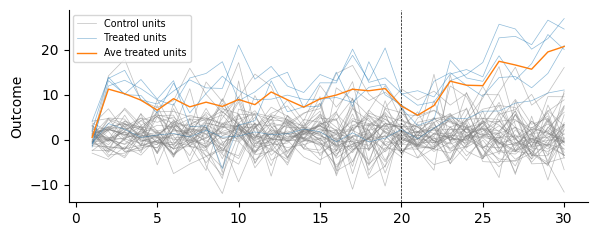

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6.7, 2.5))

pivot_co = df.query("tr_group==0").pivot(index='id', columns='year', values='y')
# Plot for control group with a specific color
for i in pivot_co.index:
    sns.lineplot(data=pivot_co.loc[i], legend=False, ax=ax, color=color[7], linewidth=0.5, alpha=0.5, label='Control units' if i==pivot_co.index[0] else None)

pivot_tr = df.query("tr_group==1").pivot(index='id', columns='year', values='y')
# Plot for treatment group with a specific color
for i in pivot_tr.index:
    sns.lineplot(data=pivot_tr.loc[i], legend=False, ax=ax, color=color[0], linewidth=0.5, alpha=0.5, label='Treated units' if i==pivot_tr.index[0] else None)

# one year before the treatment
ax.axvline(df.query("post_period==0").year.max(), color='black', linestyle='--', linewidth=0.5)

# average for treated group
sns.lineplot(data=df.query("tr_group==1").groupby('year').y.mean(), legend=False, ax=ax, color=color[1], linestyle='-', linewidth=1, label='Ave treated units')
ax.legend(fontsize='x-small')
ax.set(xlabel='', ylabel='Outcome')
sns.despine()

### SCM estimation
---

In [13]:
scm_model = scm(df=df, id='id', year='year', outcome='y', treated='treated', v=None)
scm_model.fit()

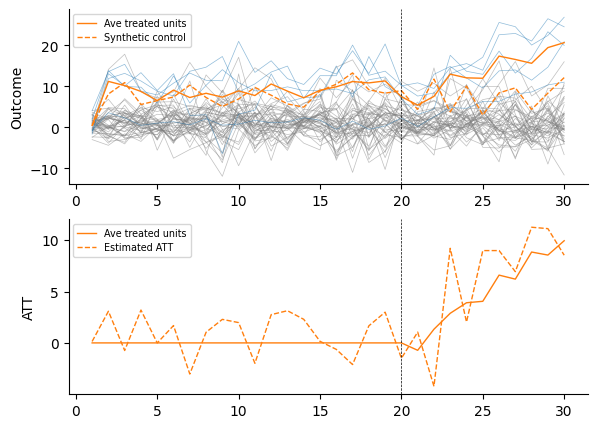

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

# Plot for control and treatment groups
sns.lineplot(data=df, x='year', y='y', hue='tr_group', estimator=None, units='id', palette=[color[7], color[0]], linewidth=0.5, alpha=0.5, ax=ax1, legend=False)

# Average for treated group and synthetic control
ave_treated = df.query("tr_group==1").groupby('year')['y'].mean()
synthetic_control = pd.Series(scm_model.Y_syn, index=ave_treated.index)

ave_treated.plot(ax=ax1, color=color[1], linestyle='-', linewidth=1, label='Ave treated units')
synthetic_control.plot(ax=ax1, color=color[1], linestyle='--', linewidth=1, label='Synthetic control')

# Add a vertical line for one year before treatment
ax1.axvline(df.query("post_period==0")['year'].max(), color='black', linestyle='--', linewidth=0.5)

# Add legend and labels
ax1.legend(fontsize='x-small')
ax1.set(xlabel='', ylabel='Outcome')

# True ATT and Estimated ATT
true_att = df.query("tr_group==1").groupby('year')['eff'].mean()
estimated_att = df.query("tr_group==1").groupby('year')['y'].mean() - synthetic_control.values

true_att.plot(ax=ax2, color=color[1], linestyle='-', linewidth=1, label='Ave treated units')
sns.lineplot(x=estimated_att.index, y=estimated_att, ax=ax2, color=color[1], linestyle='--', linewidth=1, label='Estimated ATT')

# Add vertical line for one year before treatment and customize the second subplot
ax2.axvline(df.query("post_period==0")['year'].max(), color='black', linestyle='--', linewidth=0.5)
ax2.legend(loc='upper left', fontsize='x-small')
ax2.set(xlabel='', ylabel='ATT')

sns.despine()

### GSC-IPCA estimation
---

In [15]:
# GSC-IPCA model
covariates = ['x' + str(i) for i in range(1, L+1)]
# we only observe a certain number of covariates
size = 1
L_obs = round(size*len(covariates))
obs_covariates = list(np.random.choice(covariates, size=L_obs, replace=False))

#covariates = ['x1', 'x2']
# Fit the model
gsc_ipca__model = gsc_ipca(df=df, id='id', year='year', outcome='y', covariates=obs_covariates, treated='treated', K=K, L=L_obs)
gsc_ipca__model.fit(verbose=False)

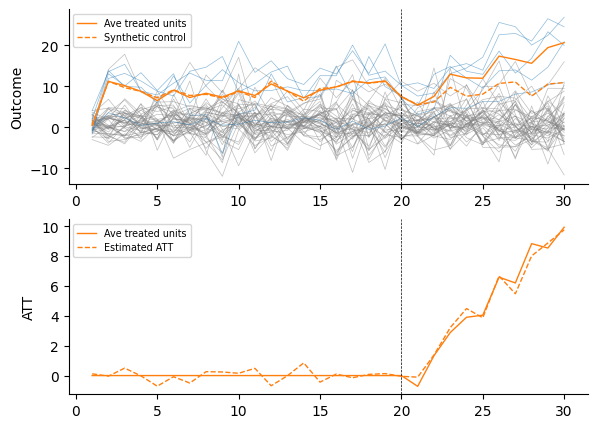

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

# Plot for control and treatment groups
sns.lineplot(data=df, x='year', y='y', hue='tr_group', estimator=None, units='id', palette=[color[7], color[0]], linewidth=0.5, alpha=0.5, ax=ax1, legend=False)

# Average for treated group and synthetic control
ave_treated = df.query("tr_group==1").groupby('year')['y'].mean()
synthetic_control = pd.Series(gsc_ipca__model.Y_syn.mean(axis=0), index=ave_treated.index)

ave_treated.plot(ax=ax1, color=color[1], linestyle='-', linewidth=1, label='Ave treated units')
synthetic_control.plot(ax=ax1, color=color[1], linestyle='--', linewidth=1, label='Synthetic control')

# Add a vertical line for one year before treatment
ax1.axvline(df.query("post_period==0")['year'].max(), color='black', linestyle='--', linewidth=0.5)

# Add legend and labels
ax1.legend(fontsize='x-small')
ax1.set(xlabel='', ylabel='Outcome')

# True ATT and Estimated ATT
true_att = df.query("tr_group==1").groupby('year')['eff'].mean()
estimated_att = df.query("tr_group==1").groupby('year')['y'].mean() - synthetic_control.values

true_att.plot(ax=ax2, color=color[1], linestyle='-', linewidth=1, label='Ave treated units')
sns.lineplot(x=estimated_att.index, y=estimated_att, ax=ax2, color=color[1], linestyle='--', linewidth=1, label='Estimated ATT')

# Add vertical line for one year before treatment and customize the second subplot
ax2.axvline(df.query("post_period==0")['year'].max(), color='black', linestyle='--', linewidth=0.5)
ax2.legend(loc='upper left', fontsize='x-small')
ax2.set(xlabel='', ylabel='ATT')

sns.despine()

### GSC-IFE estimation
---

In [17]:
# GSC-IFE model
# Fit the model
gsc_ife_model = gsc_ife(df=df, id='id', year='year', outcome='y', covariates=covariates, treated='treated', K=K)
gsc_ife_model.fit(verbose=False)

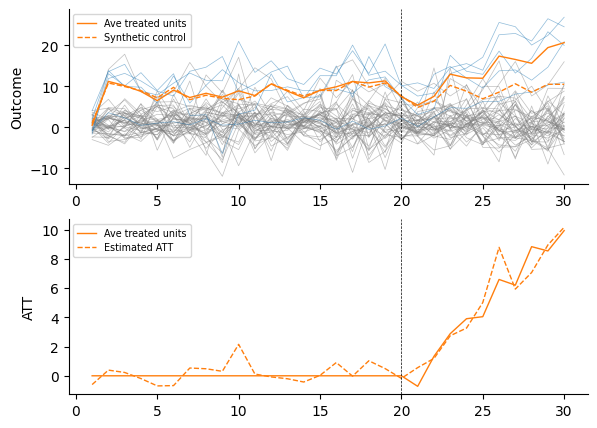

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

# Plot for control and treatment groups
sns.lineplot(data=df, x='year', y='y', hue='tr_group', estimator=None, units='id', palette=[color[7], color[0]], linewidth=0.5, alpha=0.5, ax=ax1, legend=False)

# Average for treated group and synthetic control
ave_treated = df.query("tr_group==1").groupby('year')['y'].mean()
synthetic_control = pd.Series(gsc_ife_model.Y_syn.mean(axis=1), index=ave_treated.index)

ave_treated.plot(ax=ax1, color=color[1], linestyle='-', linewidth=1, label='Ave treated units')
synthetic_control.plot(ax=ax1, color=color[1], linestyle='--', linewidth=1, label='Synthetic control')

# Add a vertical line for one year before treatment
ax1.axvline(df.query("post_period==0")['year'].max(), color='black', linestyle='--', linewidth=0.5)

# Add legend and labels
ax1.legend(fontsize='x-small')
ax1.set(xlabel='', ylabel='Outcome')

# True ATT and Estimated ATT
true_att = df.query("tr_group==1").groupby('year')['eff'].mean()
estimated_att = df.query("tr_group==1").groupby('year')['y'].mean() - synthetic_control.values

true_att.plot(ax=ax2, color=color[1], linestyle='-', linewidth=1, label='Ave treated units')
sns.lineplot(x=estimated_att.index, y=estimated_att, ax=ax2, color=color[1], linestyle='--', linewidth=1, label='Estimated ATT')

# Add vertical line for one year before treatment and customize the second subplot
ax2.axvline(df.query("post_period==0")['year'].max(), color='black', linestyle='--', linewidth=0.5)
ax2.legend(loc='upper left', fontsize='x-small')
ax2.set(xlabel='', ylabel='ATT')

sns.despine()